In [2]:
import sys
import os
from importlib import reload
from itertools import islice

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import re

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [9]:
from collections import Counter

In [10]:
# Проверяем, выполняется ли код на Kaggle
is_kaggle = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

if is_kaggle:
    # Проверка, существует ли уже клонированный репозиторий
    if not os.path.exists('/kaggle/working/smf'):
        !git clone https://github.com/kogriv/smf.git
    else:
        print("Репозиторий уже клонирован.")
else:
    print("Запуск на локальной машине, клонирование не требуется.")

Запуск на локальной машине, клонирование не требуется.


In [14]:
try:
    # Путь для локальной машины (определяем корень проекта)
    project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
    src_path = os.path.join(project_root, "src")

    # Проверяем, существует ли путь (т.е. файл "src" должен быть в корне проекта)
    if os.path.exists(src_path):
        sys.path.append(src_path)
        print("Local machine: Путь к 'src' добавлен.")
    else:
        raise FileNotFoundError(f"Path {src_path} not found on local machine.")

except:
    try:
        # Путь для Kaggle
        kaggle_src_path = '/kaggle/working/smf/src'
        if os.path.exists(kaggle_src_path):
            sys.path.append(kaggle_src_path)
            print("Kaggle: Путь к 'src' добавлен.")
        else:
            raise FileNotFoundError(f"Path {kaggle_src_path} not found on Kaggle.")

    except Exception as e:
        print(f"Не удалось добавить путь к 'src'. Ошибка: {e}")

Local machine: Путь к 'src' добавлен.


In [16]:
import promiss
import langs_clean

In [18]:
try:
    # Путь для локальной машины
    file_path = r'C:\0\smf\train.csv' 
    dtr = pd.read_csv(file_path, lineterminator='\n')
    print('Train data loaded from local machine')

except:
    try:
        # Путь для Kaggle
        file_path = '/kaggle/input/animation-reels-classification/train.csv'
        dtr = pd.read_csv(file_path, lineterminator='\n')
        print('Train data loaded from Kaggle')

    except Exception as e:
        print(f'Train data was not loaded. Error: {e}')

Train data loaded from local machine


In [20]:
try:
    # Путь для локальной машины
    file_path = r'C:\0\smf\test.csv' 
    dts = pd.read_csv(file_path, lineterminator='\n')
    print('Test data loaded from local machine')

except:
    try:
        # Путь для Kaggle
        file_path = '/kaggle/input/animation-reels-classification/test.csv'
        dts = pd.read_csv(file_path, lineterminator='\n')
        print('Test data loaded from Kaggle')

    except Exception as e:
        print(f'Test data was not loaded. Error: {e}')

Test data loaded from local machine


In [22]:
pd.set_option('display.max_colwidth', None)

In [24]:
pd.set_option('display.max_rows', None)

In [26]:
dtr[:1]

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
0,2023-12-30,100 подарков и только один можно оставить себе,PyGZL_fCbSc,none,https://www.youtube.com/watch?v=PyGZL_fCbSc,[100 подарков и только один можно оставить себе],1854.0,0.0,none,UCcartHVtvAUzfajflyeT_Gg,Miss Katy,https://www.youtube.com/channel/UCcartHVtvAUzfajflyeT_Gg,Блогеры,0.0,0.0,NaN


In [28]:
pd.reset_option('display.max_rows')

In [30]:
print('broadcast:       ',dtr.broadcast.unique())
print('yt_channel_type: ',dtr.yt_channel_type.unique())
print('flag_closed:     ',dtr.flag_closed.unique())
print('international:   ',dtr.international.unique())
print('is_shorts:       ',dtr.is_shorts.unique())

broadcast:        ['none' nan 'live' 'upcoming']
yt_channel_type:  ['Блогеры' 'Мультфильмы' 'Детские' 'Shorts' nan]
flag_closed:      [ 0.  1. nan]
international:    [ 0.  1. nan]
is_shorts:        [ 0. nan  1.]


In [32]:
pivot_shorts_seconds = dtr.pivot_table(
    values='seconds',
    index='is_shorts',
    aggfunc=['min', 'mean', 'max']
)
pivot_shorts_seconds.columns = ['min_seconds', 'mean_seconds', 'max_seconds']
pivot_shorts_seconds = pivot_shorts_seconds.reset_index()
pivot_shorts_seconds

,is_shorts,min_seconds,mean_seconds,max_seconds
0,0.0,0.0,2023.129919,504055.0
1,1.0,1.0,27.140457,60.0


In [34]:
dtr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             83411 non-null  object 
 1   reel_name        83408 non-null  object 
 2   yt_reel_id       83411 non-null  object 
 3   cartoon          83411 non-null  object 
 4   url              83411 non-null  object 
 5   text             83411 non-null  object 
 6   seconds          74653 non-null  float64
 7   is_shorts        74653 non-null  float64
 8   broadcast        74653 non-null  object 
 9   yt_channel_id    83366 non-null  object 
 10  yt_channel_name  83363 non-null  object 
 11  yt_ch_url        83363 non-null  object 
 12  yt_channel_type  83363 non-null  object 
 13  flag_closed      83363 non-null  float64
 14  international    83363 non-null  float64
 15  language         497 non-null    object 
dtypes: float64(4), object(12)
memory usage: 10.2+ MB


In [36]:
dts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55608 entries, 0 to 55607
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             55608 non-null  object 
 1   reel_name        55605 non-null  object 
 2   yt_reel_id       55608 non-null  object 
 3   url              55608 non-null  object 
 4   text             55608 non-null  object 
 5   seconds          49807 non-null  float64
 6   is_shorts        49807 non-null  float64
 7   broadcast        49807 non-null  object 
 8   yt_channel_id    55584 non-null  object 
 9   yt_channel_name  55580 non-null  object 
 10  yt_ch_url        55580 non-null  object 
 11  yt_channel_type  55580 non-null  object 
 12  flag_closed      55580 non-null  float64
 13  international    55580 non-null  float64
 14  language         337 non-null    object 
dtypes: float64(4), object(11)
memory usage: 6.4+ MB


In [38]:
dtr.yt_reel_id.nunique()

83411

In [40]:
dtr.cartoon.nunique()

45

In [42]:
dtr.cartoon.value_counts(normalize=True)[:5]

none               0.937898
Маша и медведь     0.010226
Говорящий Том      0.007061
Буба               0.006342
Кошечки собачки    0.005239
Name: cartoon, dtype: float64

In [44]:
dtr.duplicated().sum()

0

Дубликатов нет

## Пропуски

In [47]:
# reload(promiss)

Использую класс обработчик пропусков в соответствии с указаниями для каждого поля

In [50]:
# promiss.missval_dict

In [52]:
missval_handler = promiss.MissingValueHandler(fill_strategy = 'custom_basic', fill_values = promiss.missval_dict)

In [54]:
# Подгоняем обработчик на тренировочных данных, исключая целевую переменную 'cartoon'
missval_handler.fit(dtr)

MissingValueHandler(fill_strategy='custom_basic',
                    fill_values={'broadcast': 'agg_mode_by_yt_channel_type',
                                 'cartoon': 'value_none', 'date': 'agg_mode',
                                 'flag_closed': 'agg_mode',
                                 'international': 'agg_mode',
                                 'is_shorts': 'agg_mode',
                                 'language': 'value_NA',
                                 'reel_name': 'value_NA',
                                 'seconds': 'agg_median_by_yt_channel_type',
                                 'text': 'value_NA', 'url': 'value_NA',
                                 'yt_ch_url': 'value_NA',
                                 'yt_channel_id': 'value_NA',
                                 'yt_channel_name': 'value_NA',
                                 'yt_channel_type': 'agg_mode',
                                 'yt_reel_id': 'drop'})

In [56]:
# dtr.loc[:, dtr.columns != 'cartoon']

In [58]:
# Применяем обработчик к тренировочным данным, исключая 'cartoon'
# dtr.loc[:, dtr.columns != 'cartoon'] = missval_handler.transform(dtr.drop(columns=['cartoon']))
dtr = missval_handler.transform(dtr)

In [60]:
# Применяем обработчик к тестовым данным, исключая 'cartoon'
# dts.loc[:, dts.columns != 'cartoon'] = missval_handler.transform(dts.drop(columns=['cartoon']))
dts = missval_handler.transform(dts)

In [62]:
dtr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             83411 non-null  object 
 1   reel_name        83411 non-null  object 
 2   yt_reel_id       83411 non-null  object 
 3   cartoon          83411 non-null  object 
 4   url              83411 non-null  object 
 5   text             83411 non-null  object 
 6   seconds          83411 non-null  float64
 7   is_shorts        83411 non-null  float64
 8   broadcast        83411 non-null  object 
 9   yt_channel_id    83411 non-null  object 
 10  yt_channel_name  83411 non-null  object 
 11  yt_ch_url        83411 non-null  object 
 12  yt_channel_type  83411 non-null  object 
 13  flag_closed      83411 non-null  float64
 14  international    83411 non-null  float64
 15  language         83411 non-null  object 
dtypes: float64(4), object(12)
memory usage: 10.2+ MB


# Определим языки

Для определения языков текстов были использованы функции библитеки langdetect. Но, поскольку обработка всего датасета происходит очень долго, результат распределения был сохранен в модуле langs_clean. Общая информация ниже:

In [66]:
# Всего детектировано языков в трэйне
len(langs_clean.lang_distrib_train)

40

In [68]:
# Первая десятка
dict(islice(langs_clean.lang_distrib_train.items(), 10))

{'ru': 0.790567,
 'en': 0.15209,
 'bg': 0.01296,
 'pl': 0.009064,
 'ja': 0.006546,
 'pt': 0.006138,
 'et': 0.005815,
 'ar': 0.003369,
 'uk': 0.003105,
 'es': 0.002805}

'bg' - детектировался как болгарский язык, но посмотрев несколько экземпляров, обнаружил, что это русские тексты.

# Анализ классов (выявление дисбаланса)

In [72]:
import imba

In [74]:
# reload(imba)

Class distribution:
 none                          0.937898
Маша и медведь                0.010226
Говорящий Том                 0.007061
Буба                          0.006342
Кошечки собачки               0.005239
Енотки                        0.004544
Бэтмен                        0.004232
ЖилаБыла Царевна              0.002745
Оранжевая корова              0.002721
Зебра в клеточку              0.002254
Фиксики                       0.001810
Чик-Чирикино                  0.001642
Сумка                         0.001607
Черепашки Ниндзя              0.001247
Чуддики                       0.001031
My little pony                0.000971
Свинка Пеппа                  0.000827
Синий трактор                 0.000803
Чучело-Мяучело                0.000767
Малышарики                    0.000719
Пороро                        0.000611
Приключения Пети и Волка      0.000492
Смешарики                     0.000492
Трансформеры                  0.000480
Простоквашино                 0.000420
Царе

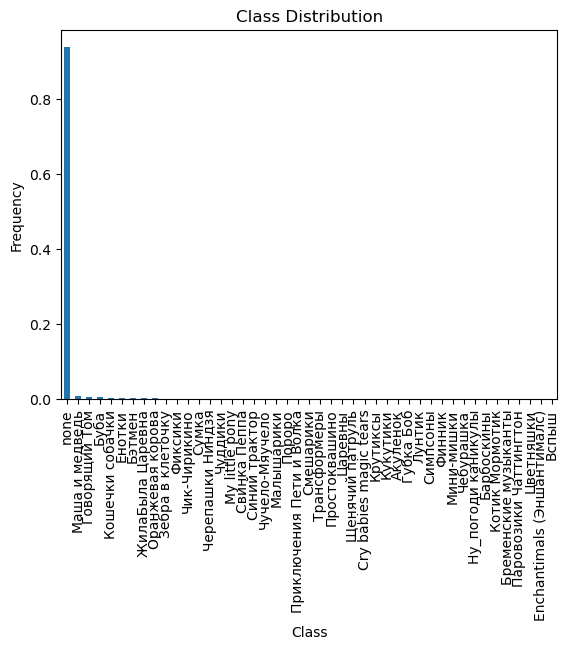

In [76]:
imba.plot_class_distribution(dtr,target_column='cartoon', rare_class_only=False, verbose=True)

Посмотрим только редкие классы

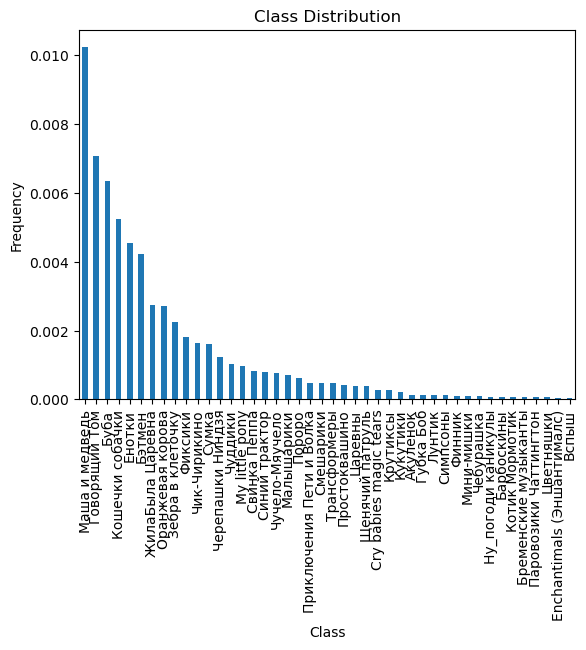

In [79]:
imba.plot_class_distribution(dtr,target_column='cartoon', rare_class_only=True, verbose=False)

В модуле imba реализованы методы балансировки с помощью SMOTE, но, поскольку будут использоваться модели со встроенными методами работы с насбалансированными классами, на данном этапе датасет не обрабатываю.

# Модели

In [83]:
import torch
from torch import nn
from transformers import AutoModel, AutoTokenizer

Создадим гибридную модель (Трансформер + Dense Layers)

- Используем трансформер для обработки текстовых данных.
- Параллельно обрабатываем не текстовые данные с помощью Dense (полносвязных) слоев.
- Объединяем выходы трансформера и Dense слоев перед финальной классификацией.

In [86]:
class HybridModel(nn.Module):
    def __init__(self, transformer_model_name, num_labels, num_numeric_features):
        super(HybridModel, self).__init__()
        
        # Модель трансформера для текстов
        self.transformer = AutoModel.from_pretrained(transformer_model_name)
        
        # Полносвязный слой для обработки текстовых данных
        self.text_fc = nn.Linear(self.transformer.config.hidden_size, 128)
        
        # Полносвязный слой для числовых данных (и других нетекстовых признаков)
        self.numeric_fc = nn.Linear(num_numeric_features, 128)
        
        # Финальный классификационный слой
        self.classifier = nn.Linear(128 * 2, num_labels)
        
    def forward(self, text_input, numeric_input):
        # Обрабатываем текстовые данные через трансформер
        transformer_output = self.transformer(**text_input).pooler_output
        text_features = self.text_fc(transformer_output)
        
        # Обрабатываем числовые данные
        numeric_features = self.numeric_fc(numeric_input)
        
        # Объединяем текстовые и числовые признаки
        combined_features = torch.cat((text_features, numeric_features), dim=1)
        
        # Применяем финальный классификационный слой
        logits = self.classifier(combined_features)
        
        return logits

Токенизируем текстовые данные с помощью токенизатора трансформера

In [89]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
text_encodings = tokenizer(list(dtr['text']), truncation=True, padding=True, return_tensors="pt")

Преобразуем числовые/категориальные признаки (например, длину ролика, тип канала) в тензоры.

In [92]:
numeric_features = torch.tensor(dtr[['seconds', 'flag_closed', 'international']].values, dtype=torch.float32)

Обучение модели: Создадим экземпляр гибридной модели и обучим её:

In [95]:
num_classes = 46

In [97]:
model = HybridModel('xlm-roberta-base', num_labels=num_classes, num_numeric_features=numeric_features.shape[1])

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Вычислим веса классов на основе их частоты в данных

In [100]:
le = LabelEncoder()
y_train = le.fit_transform(dtr['cartoon'])

In [102]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [104]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
# criterion = nn.CrossEntropyLoss()
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

In [106]:
num_epochs = 5

In [108]:
# Пример цикла обучения
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    logits = model(text_encodings, numeric_features)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

RuntimeError: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 131194159104 bytes.